In [57]:
!pip install mmh3
!pip install ipython-autotime
%load_ext autotime

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 29 s (started: 2023-12-15 04:55:11 +00:00)


In [58]:
import random
from sklearn.utils import murmurhash3_32
import math
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import heapq
import matplotlib.pyplot as plt
import numpy as np
from nltk import trigrams, word_tokenize

time: 1.22 ms (started: 2023-12-15 04:55:40 +00:00)


In [59]:
def preproc(text, ngram =3):
    ngram_list = [text[i:i+ngram] for i in range(len(text)-(ngram-1))]
    return ngram_list

def hash_factory(seed_val):
    return lambda x: murmurhash3_32(x, seed = seed_val)

def MinHash(text, seed=512, m=100):
    random.seed(seed)
    seed_list = random.sample(range(10*m),m)
    hashes = [hash_factory(seed_list[i]) for i in range(m)]
    return [min([hash(x) for x in text]) for hash in hashes]

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

time: 3.07 ms (started: 2023-12-15 04:55:40 +00:00)


In [60]:
class HashTable ():
    def __init__ (self , k, l, b, r):
        self.k = k
        self.l = l
        self.b = b
        self.r = r
        self.hashtables = [{} for idx in range(self.l)]

    def insert (self , hashcodes , id):
        for num10 in range(self.l):
            codes = tuple(hashcodes[(num10*self.k):(num10*self.k)+self.k])
            if codes not in self.hashtables[num10]:
                self.hashtables[num10][codes] = []
            if len(self.hashtables[num10][codes]) < self.b:
                self.hashtables[num10][codes].append(id)
          #print(codes,self.hashtables[idx][codes])
        return

    def lookup (self , hashcodes):
        ids = set()
        for idx in range(self.l):
            codes = tuple(hashcodes[(idx*self.k):(idx*self.k)+self.k])
            if codes in self.hashtables[idx]:
                ids.update(self.hashtables[idx][codes])
        return ids



time: 2.5 ms (started: 2023-12-15 04:55:40 +00:00)


In [61]:
data = pd.read_csv("/kaggle/input/amazon-product-dataset-2020/home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv")
print("Total Number of rows for raw data", data.shape[0])
data['Selling Price'] = data['Selling Price'].fillna('')
condition = ~data['Selling Price'].str.contains('[a-zA-Z]') & (data['Selling Price'].str.count('\$') <= 1)
clear_data = data[condition].copy()
clear_data['Selling Price'] = pd.to_numeric(clear_data['Selling Price'].str.replace(',', '').str.replace('$', ''), errors='coerce')

#clear_data['Selling Price'] = clear_data['Selling Price'].str.replace(',', '').str.replace('$', '').astype(float)
clear_data = clear_data.dropna(subset=['Product Name', 'Category','Selling Price'])[['Product Name', 'Category','Selling Price']].reset_index(drop=True)
print("Total Number of rows after clearning empty cells", clear_data.shape[0])
tot_len = clear_data.shape[0]

Total Number of rows for raw data 10002
Total Number of rows after clearning empty cells 8716
time: 475 ms (started: 2023-12-15 04:55:40 +00:00)


In [62]:
clear_data = clear_data.rename_axis('ID')
clear_data.head(10)

,Product Name,Category,Selling Price
ID,,,
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Sports & Outdoors | Outdoor Recreation | Skate...,237.68
1,"Electronic Snap Circuits Mini Kits Classpack, ...",Toys & Games | Learning & Education | Science ...,99.95
2,3Doodler Create Flexy 3D Printing Filament Ref...,Toys & Games | Arts & Crafts | Craft Kits,34.99
3,Guillow Airplane Design Studio with Travel Cas...,Toys & Games | Hobbies | Models & Model Kits |...,28.91
4,Woodstock- Collage 500 pc Puzzle,Toys & Games | Puzzles | Jigsaw Puzzles,17.49
5,Rubie's Child's Pokemon Deluxe Pikachu Costume...,"Clothing, Shoes & Jewelry | Costumes & Accesso...",29.12
6,Hoffmaster 120813 Double-Tipped Triangular Cra...,Toys & Games | Arts & Crafts | Drawing & Paint...,97.68
7,"ARTSCAPE Etched Glass 24"" x 36"" Window Film, 2...",Home & Kitchen | Home Décor | Window Treatment...,12.99
8,"Moonlite, 3-Story Bundle for Boys, Includes 3 ...",Toys & Games | Baby & Toddler Toys,18.16


time: 12 ms (started: 2023-12-15 04:55:41 +00:00)


In [63]:
pname_text = [preproc(clear_data["Product Name"].iloc[idx], ngram =3) for idx in tqdm(range(tot_len))]
cat_text = [preproc(clear_data["Category"].iloc[idx], ngram =3) for idx in tqdm(range(tot_len))]


pname_ngrams_list = []
for idx in tqdm(range(tot_len)):
  pname_ngrams_list.append(MinHash(text = pname_text[idx], m =100))

cat_ngrams_list = []
for idx in tqdm(range(tot_len)):
  cat_ngrams_list.append(MinHash(text = cat_text[idx], m =100))



100%|██████████| 8716/8716 [00:50<00:00, 173.72it/s]

time: 1min 43s (started: 2023-12-15 04:55:41 +00:00)


In [64]:
clear_data = clear_data.reset_index()
train_data, val_data = train_test_split(clear_data, test_size=0.1, random_state=42)

time: 7.04 ms (started: 2023-12-15 04:57:25 +00:00)


In [65]:
train_data.head(10)
train_data.shape

(7844, 4)

time: 7.09 ms (started: 2023-12-15 04:57:25 +00:00)


In [66]:
l = 50
k = 2
hashtable1 = HashTable(k=2, l=50, b=64, r = pow(2,20))
for idx in range(train_data.shape[0]):
    num = train_data["ID"].iloc[idx]
    pname_ngrams = pname_ngrams_list[num][:k*l]
    hashtable1.insert(hashcodes = pname_ngrams, id = num)

hashtable2 = HashTable(k=2, l=50, b=64, r = pow(2,20))
for idx in range(train_data.shape[0]):
    num = train_data["ID"].iloc[idx]
    cat_ngrams = cat_ngrams_list[num][:k*l]
    hashtable2.insert(hashcodes = cat_ngrams, id = num)

time: 2.54 s (started: 2023-12-15 04:57:25 +00:00)


In [67]:
cat_proc = clear_data

time: 429 µs (started: 2023-12-15 04:57:27 +00:00)


In [68]:
train_pname = pd.DataFrame(train_data["Product Name"].apply(trigrams).apply(set))
train_pname
train_cat = pd.DataFrame(train_data["Category"].apply(lambda x: set(x.split(" | "))).apply(set))
train_cat

,Category
5698,"{Scrapbooking & Stamping, Arts, Crafts & Sewin..."
2312,"{Jigsaw Puzzles, Toys & Games, Puzzles}"
1672,"{Sports & Outdoors, Portable, Accessories, Spo..."
2138,"{Die-Cast Vehicles, Toys & Games, Play Vehicles}"
1438,"{Bouncers, Jumpers & Swings, Baby Products, Ac..."
...,...
5734,"{Toys & Games, Games & Accessories}"
5191,"{Tricycles, Scooters & Wagons, Toys & Games, R..."
5390,"{Pacifiers, Teethers & Teething Relief, Baby P..."
860,"{Magnifying Tools, Hobby Building Tools & Hard..."


time: 438 ms (started: 2023-12-15 04:57:27 +00:00)


In [69]:
cum_jac = 0
counter = 0
top_sim = 0
len_top10 = 0
variance_list = []
for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    pname_ids = hashtable1.lookup(pname_ngrams_list[num])
    cat_ids = hashtable2.lookup(cat_ngrams_list[num])
    sim_dict = {}

    p_bucket = train_pname.loc[list(pname_ids)]
    c_bucket = train_cat.loc[list(cat_ids)]

    val_grams = set(trigrams(val_data.loc[val_data['ID'] == num, 'Product Name'].values[0]))
    val_grams_cat = set(val_data.loc[val_data['ID'] == num, 'Category'].apply(lambda x: set(x.split(" | "))).values[0])
    
    jac_sim = lambda x: jaccard_similarity(x["Product Name"], val_grams)
    jac_sim_cat = lambda x: jaccard_similarity(x["Category"], val_grams_cat) * 0.8
    
    if not p_bucket.empty:
        _col = p_bucket.apply(jac_sim, axis=1)
        _col = pd.concat([_col, c_bucket.apply(jac_sim_cat, axis=1)])
    else:
        _col = c_bucket.apply(jac_sim_cat, axis=1)

    _col = _col.sort_values(ascending=False)

    top_ids = list(_col.index)[:3]
    average_price = clear_data[clear_data['ID'].isin(top_ids)]['Selling Price'].mean()
    if abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]) < 3:
        variance_list.append(abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]))
    #print(variance_list)
    #print(average_price,clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])

print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))
print("standard deviation", np.std(variance_list))

100%|██████████| 872/872 [00:17<00:00, 50.79it/s]

mean variance: 0.6520966752181071
median variance 0.44474093840337997
standard deviation 0.6559996472896665
time: 17.2 s (started: 2023-12-15 04:57:28 +00:00)


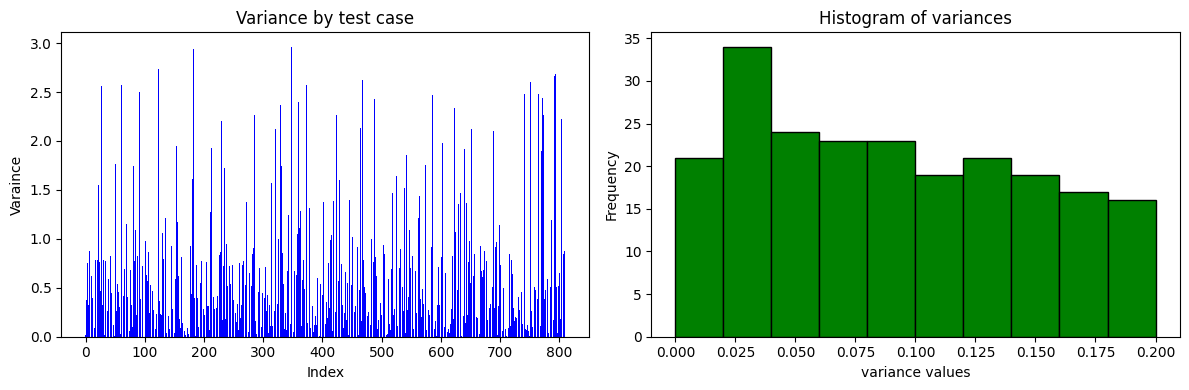

time: 2.07 s (started: 2023-12-15 04:57:45 +00:00)


In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Varaince')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()

# Bruteforce

In [71]:
from sklearn.metrics import jaccard_score


time: 442 µs (started: 2023-12-15 04:57:47 +00:00)


In [72]:
variance_list = []

for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    sim_dict = {}

    val_grams = set(trigrams(val_data.loc[val_data['ID'] == num, 'Product Name'].values[0]))
    val_grams_cat = set(val_data.loc[val_data['ID'] == num, 'Category'].apply(lambda x: set(x.split(" | "))).values[0])
    
    jac_sim = lambda x: jaccard_similarity(x["Product Name"], val_grams)
    jac_sim_cat = lambda x: jaccard_similarity(x["Category"], val_grams_cat) * 0.8

    _col = train_pname.apply(jac_sim, axis=1)
    _col = pd.concat([_col, train_cat.apply(jac_sim_cat, axis=1)]).sort_values(ascending=False)
    
    top_ids = list(_col.index)[:3]
    average_price = clear_data[clear_data['ID'].isin(top_ids)]['Selling Price'].mean()
    if abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]) < 3:
        variance_list.append(abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]))
    #print(variance_list)
    #print(average_price,clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])
variance_list = np.array(variance_list)
variance_list = variance_list[~np.isnan(variance_list)]
print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))
print("standard deviation", np.std(variance_list))

100%|██████████| 872/872 [03:56<00:00,  3.69it/s]

mean variance: 0.5948457679988821
median variance 0.42577131995689477
standard deviation 0.5812335696076291
time: 3min 56s (started: 2023-12-15 04:57:47 +00:00)


In [73]:

print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))

mean variance: 0.5948457679988821
median variance 0.42577131995689477
time: 1.26 ms (started: 2023-12-15 05:01:43 +00:00)


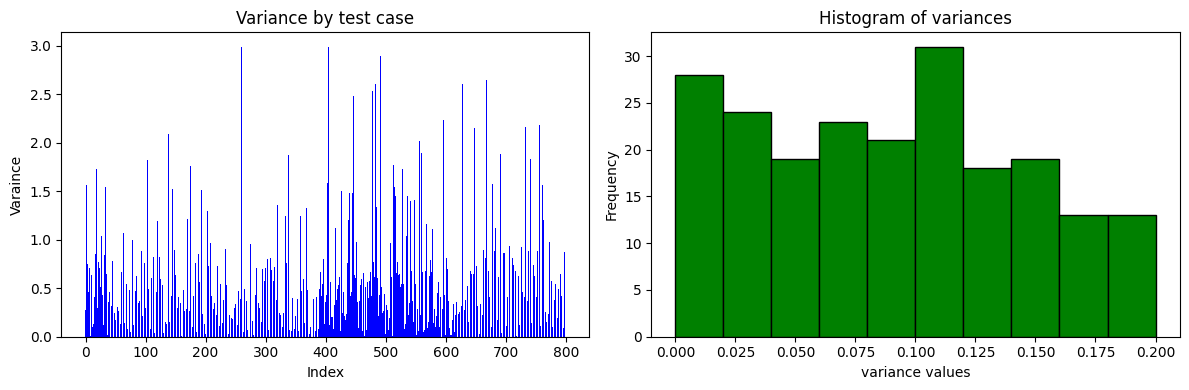

time: 2.03 s (started: 2023-12-15 05:01:43 +00:00)


In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Varaince')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()